In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json
import scipy.stats as st
from scipy.stats import gaussian_kde

%matplotlib inline
plt.rcParams.update({'font.size': 12})
# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

In [3]:
DA_dir = Path.cwd() / "models"
noDA_dir = Path.cwd().parent / "FinalPaperMVEnoDAv2" / "models"
lets = list("abcde".upper())
DA_paths = [DA_dir / ("Run" + i + "_snll") for i in lets]
noDA_paths = [noDA_dir / ("Run" + i + "_noDA_snll") for i in lets]

In [4]:
def get_models(paths):
    mods = []
    stats = []
    for mod_path in paths:
        mod_json = mod_path.parent / (mod_path.name + ".json")
        model = NeuralNetworkMVEv3(npix=40).cuda()
        model.load_state_dict(torch.load(mod_path)['state_dict'])
        stats.append(json.load(open(mod_json, 'r')))
        mods.append(model)

        
    return mods, stats

def get_test_predictions(model, test_dataloader):
    all_mean = []
    all_var = []
    all_truth = []
    
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.float()
            
            pred, _ = model(X.cuda())
            mean = list(pred[:, 0].cpu().numpy())
            var = list(pred[:, 1].cpu().numpy())
            truth = list(y.cpu().numpy())

            all_mean = all_mean + mean
            all_var = all_var + var
            all_truth = all_truth + truth

    return np.array(all_mean), np.array(all_var), np.array(all_truth)

def evaluate_nll(mean, var, truth):
    var = torch.tensor(var)
    nll = float(loss_bnll(mean, var, truth, beta = 0.0))
    return nll

def evaluate_r2(mean, truth):
    return r2_score(truth, mean)


def calculate_coverage(mean, var, truth):
    """
    Calculates the fraction of images with correct prediction within each confidence level (0% - 100%).
    This assumes the variance is based on a gaussian distribution.
    
    E.g. In 100 lenses, if 30 lenses have predictions within a 50% confidence interval, the point
    (50, 30) will be present.

    At 0%, no lenses should be in the confidence interval. 
    At 100%, all lenses should be in the confidence interval.
    """

    # Convert variance to standard deviation
    sig = np.sqrt(var)

    # Calculate zscore = (x - mu) / sig, and take absolute value, e.g. 1.96
    zscore = np.abs((mean - truth) / sig)

    # Calculate the fraction of gaussian within zscore sigma for two-tailed gaussian
    one_tail_cl = st.norm.cdf(zscore) # e.g. cdf(1.96) = 0.975 = 97.5% of gaussian
    two_tail_cl = 1 - ((1 - one_tail_cl) * 2) # total gaussian - ((excluded 2.5% of gaussian) * 2)

    # Above (two_tail_cl)% confidence, image will be excluded from correct prediction
    # Equivalently, we can sort the array against the fraction of lenses
    confidence_level = np.sort(two_tail_cl)
    image_fraction = np.arange(len(two_tail_cl)) / len(two_tail_cl)

    return confidence_level, image_fraction


def print_score(name, vals):
    print(name + ":", np.median(vals).round(4), "+-", np.std(vals).round(4))

def random_residual_sample(var, truth, n_points = 30):
    # Define theta_E bins
    bins = np.linspace(1.1, 2.9, n_points * 2)

    # Sort all images into respective bins
    indices = np.digitize(truth, bins) - 1 

    # Choose random point for every alternate bin
    # Variance should not be zero
    ord_idx = np.array([np.random.choice(np.where((indices == k) & (var > 0))[0], 1) for k in range(0, n_points * 2, 2)])

    # waht did i do this for again?
    rand_idx = ord_idx[:, 0]

    return rand_idx

def get_kde(resid, lims = 0.6):
    # KDE estimation
    kde = gaussian_kde(resid, bw_method=0.5)
    x_vals = np.linspace(-lims, lims, 1000)
    kde_values = kde(x_vals)

    return x_vals, kde_values

def split_mvt(mvt, i):
    return mvt[i, 0], mvt[i, 1], mvt[i, 2]

In [5]:
DA_models, DA_stats = get_models(DA_paths)
noDA_models, noDA_stats = get_models(noDA_paths)

In [10]:
model_types = {'DA': DA_models, 'noDA': noDA_models}
dataloaders = {'source': source_test_dataloader, 'target': target_test_dataloader}

# Initialize dictionaries for predictions and metrics
mvt = {}
nll_scores = {}
r2_scores = {}
coverage_scores = {}

# Get predictions and evaluate metrics
for model_type, models in model_types.items():
    for data_type, dataloader in dataloaders.items():
        
        key = f"{model_type}_{data_type}"
        mvt[key] = {}
        nll_scores[key] = {}
        r2_scores[key] = {}
        coverage_scores[key] = {}
        
        for imod, mod in enumerate(models):
            
            mvt[key][imod] = dict.fromkeys(["mean", "var", "truth"])
            curr_mvt = mvt[key][imod]

            curr_mvt["mean"], curr_mvt["var"], curr_mvt["truth"] = get_test_predictions(mod, dataloader)
            nll_scores[key][imod] = evaluate_nll(curr_mvt["mean"], curr_mvt["var"], curr_mvt["truth"])
            r2_scores[key][imod] = evaluate_r2(curr_mvt["mean"], curr_mvt["truth"])
            coverage_scores[key][imod] = calculate_coverage(curr_mvt["mean"], curr_mvt["var"], curr_mvt["truth"])

/tmp/ipykernel_2552/2459082981.py:59: RuntimeWarning: divide by zero encountered in divide
  zscore = np.abs((mean - truth) / sig)


In [15]:
for model_type, models in model_types.items():
    for data_type, dataloader in dataloaders.items():
        key = f"{model_type}_{data_type}"
        print_score("R2 " + key, list(r2_scores[key].values()))

R2 DA_source: 0.9917 +- 0.0018
R2 DA_target: 0.9861 +- 0.0023
R2 noDA_source: 0.9986 +- 0.0003
R2 noDA_target: 0.9724 +- 0.0206


In [16]:
for model_type, models in model_types.items():
    for data_type, dataloader in dataloaders.items():
        key = f"{model_type}_{data_type}"
        print_score("NLL " + key, list(nll_scores[key].values()))

NLL DA_source: -2.428 +- 0.1402
NLL DA_target: -2.2867 +- 0.1386
NLL noDA_source: -3.3583 +- 0.1302
NLL noDA_target: 4.686 +- 6770.5694


NameError: name 'cc_DA_source' is not defined

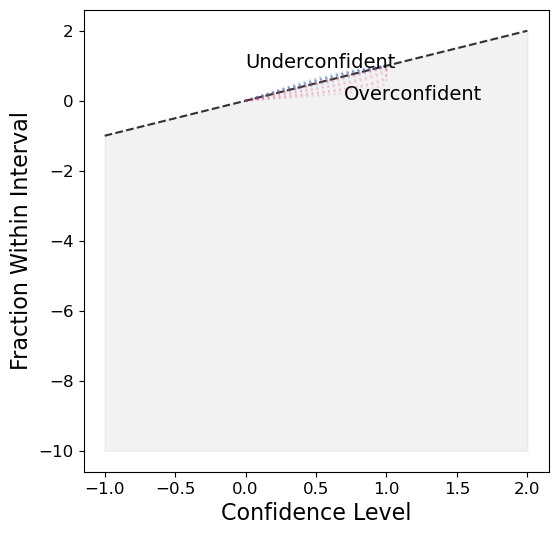

In [20]:
#plt.title("Coverage Plot", fontsize = 20)
plt.figure(figsize = (6, 6))
plt.xlabel("Confidence Level", fontsize = 16)
plt.ylabel("Fraction Within Interval", fontsize = 16)
plt.annotate("Underconfident", xy = (0, 0.95), fontsize = 14)
plt.annotate("Overconfident", xy = (0.7, 0.02), fontsize = 14)

plt.fill_between([-1, 2], [-1, 2], y2 = -10, alpha = 0.05, color = 'k')
plt.plot([-1, 2], [-1, 2], color = "k", ls = "--", alpha = 0.8)


color_opts = ['#005AB5', '#1A85FF', '#DC3220', '#D41159']

ci = 0
for model_type, models in model_types.items():
    for data_type, dataloader in dataloaders.items():
        key = f"{model_type}_{data_type}"
        
        for imod in range(len(models)):
            plt.plot(coverage_scores[key][imod][0], coverage_scores[key][imod][1], color = color_opts[ci], alpha = 0.15, ls = ":")
            
        ci += 1
        
# for mod in lDA:
#     plt.plot(cc_DA_source[mod, 0], cc_DA_source[mod, 1], color = '#005AB5', alpha = 0.15) 
#     plt.plot(cc_DA_target[mod, 0], cc_DA_target[mod, 1], color = '#1A85FF', alpha = 0.15, ls = ":") 

# for mod in lnoDA:
#     plt.plot(cc_noDA_source[mod, 0], cc_noDA_source[mod, 1], color = '#DC3220', alpha = 0.15) 
#     plt.plot(cc_noDA_target[mod, 0], cc_noDA_target[mod, 1], color = '#D41159', alpha = 0.15, ls = ":") 
    
# plt.plot(cc_DA_source[:, 0].mean(axis = 0), cc_DA_source[mod, 1], lw = 2, label = "MVE-UDA Source", color = '#005AB5')
# plt.plot(cc_DA_target[:, 0].mean(axis = 0), cc_DA_target[mod, 1], lw = 2, label = "MVE-UDA Target", color = '#1A85FF', ls = ":")
# plt.plot(cc_noDA_source[:, 0].mean(axis = 0), cc_noDA_source[mod, 1], lw = 2, label = "MVE-Only Source", color = '#DC3220')
# plt.plot(cc_noDA_target[:, 0].mean(axis = 0), cc_noDA_target[mod, 1], lw = 2, label = "MVE-Only Target", color = '#D41159',ls = ":") 


plt.legend(fontsize = 10, loc = (0.05, 0.6))
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

#plt.savefig("figures/coverage.png", bbox_inches = 'tight', dpi = 400)

In [19]:
coverage_scores['DA_source'][0]

(array([4.39100685e-05, 7.25332572e-05, 1.07922754e-04, ...,
        9.99999762e-01, 1.00000000e+00, 1.00000000e+00]),
 array([0.0000e+00, 5.0000e-05, 1.0000e-04, ..., 9.9985e-01, 9.9990e-01,
        9.9995e-01]))

In [56]:
i = 2

results_DA_source = {}
results_DA_target = {}
results_noDA_source = {}
results_noDA_target = {}

results_DA_source["mean"], results_DA_source["var"], results_DA_source["truth"] = split_mvt(mvt_DA_source, i)
results_DA_target["mean"], results_DA_target["var"], results_DA_target["truth"] = split_mvt(mvt_DA_target, i)
results_noDA_source["mean"], results_noDA_source["var"], results_noDA_source["truth"] = split_mvt(mvt_noDA_source, i)
results_noDA_target["mean"], results_noDA_target["var"], results_noDA_target["truth"] = split_mvt(mvt_noDA_target, i)

idx = random_residual_sample(var, truth)
x_kde, y_kde = get_kde(mean - truth, lims = 0.6)

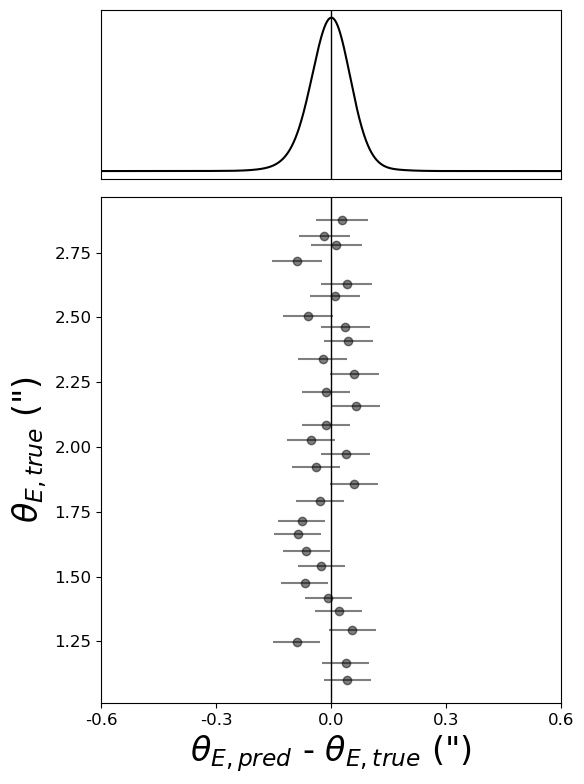

In [57]:
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))

# Plot the histogram
ax_hist.plot(x_kde, y_kde, color = 'k')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=(mean-truth)[idx], y=truth[idx], xerr=np.sqrt(var)[idx], fmt='o', alpha=0.5, ecolor = 'k', color = 'k', label = "Sample")
ax_resid.set_xlabel(r'$\theta_{E, pred}$ - $\theta_{E, true}$ (")', fontsize = 24)
ax_resid.set_ylabel(r'$\theta_{E, true}$ (")', fontsize = 24)
ax_resid.axvline(0, color = 'k', ls = '-', lw = 1)
ax_hist.axvline(0, color = 'k', ls = '-', lw = 1)

# ax_hist.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "1$\sigma$", color = '#0C7BDC')
# ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "1$\sigma$", color = '#0C7BDC')
# ax_hist.axvline(mn, color = '#FFC20A', ls = '--', lw = 2)
# ax_resid.axvline(mn, color = '#FFC20A', ls = '--', lw = 2)
# ax_resid.legend(loc = 'upper left', fontsize = 10)


lims = 0.6
xt = np.linspace(-lims, lims, 5).round(2)
ax_resid.set_xticks(xt)
ax_resid.set_xticklabels(xt)
ax_hist.set_xticks([])
ax_hist.set_yticks([])
ax_hist.set_yticklabels([])
ax_hist.set_xlim(-lims, lims)
ax_resid.set_xlim(-lims, lims)

plt.tight_layout()

In [ ]:
# Isomap

axlim = 5
cx = -8
cy = 3
n = 500
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5),)
s = ax1.scatter(trained_source_iso[:, 0][:n], trained_source_iso[:, 1][:n], s=150, marker='2', alpha = 0.8, c = isomap_source_label_sample[:n], 
           label = "Source")
ax1.scatter(trained_target_iso[:, 0][:n], trained_target_iso[:, 1][:n], s=150, marker='.', alpha = 0.5, c = isomap_target_label_sample[:n],
           label = "Target")
ax1.set_xlim(-axlim + cx, axlim + cx)
ax1.set_ylim(-axlim + cy, axlim + cy)
ax1.set_title('MVE-UDA', fontsize = 25)

# Remove axis ticks and labels
# xl, xr = ax1.get_xlim()
# yl, yr = ax1.get_ylim()
# xt = np.int32(np.linspace(xl, xr, 5))
# yt = np.int32(np.linspace(yl, yr, 5))

# ax1.set_xticks(xt)
# ax1.set_yticks(yt)
# ax1.set_xticklabels(xt)
# ax1.set_yticklabels(yt)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.legend(fontsize = 15)
cbar = plt.colorbar(s, ax = ax1)
cbar.set_label("$\\theta_E$ (\")",size=18)
cbar.ax.tick_params(labelsize=12) #.set_label(label = "$\\theta_E$ (\")", labelsize=18)
plt.savefig("post_isomap_da.png", bbox_inches = 'tight', dpi = 400)